In [1796]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import scipy

In [1797]:
def get2d(h,g):
    H = np.outer(h, h)
    G_1 = np.outer(h, g)
    G_2 = np.outer(g, h)
    G_3 = np.outer(g, g)
    return H, G_1, G_2, G_3

def rev2d(H, G_1, G_2, G_3):
    H_rev = H[::-1,::-1]
    G_1_rev = G_1[::-1,::-1]
    G_2_rev = G_2[::-1,::-1]
    G_3_rev = G_3[::-1,::-1]
    return H_rev, G_1_rev, G_2_rev, G_3_rev

def read_image_as_array(image_path):
    # Open the image using Pillow and convert it to a NumPy array
    image = Image.open(image_path).convert('L')  # 'L' mode for grayscale
    image_array = np.array(image)
    return image_array

def plt_img(data):
    plt.figure(figsize=(12, 8))
    vmin, vmax = 0, 256
    # Display the image with adjusted display range
    plt.imshow(data, cmap='gray')
    plt.show()

In [1798]:
tap =6

In [1799]:
h_db1 = np.array([1,1])/np.sqrt(2)
g_db1 = np.array([1,-1])/np.sqrt(2)

h_db2 = np.array([0.6830127,1.1830127,0.3169873,-0.1830127])/np.sqrt(2)
g_db2 = np.array([0.1830127,0.3169873,-1.1830127,0.6830127])/np.sqrt(2)

h_db3 = np.array([0.47046721,1.14111692,0.650365,-0.19093442,-0.12083221,0.0498175])/np.sqrt(2)
g_db3 = np.array([-0.0498175,-0.12083221,0.19093442,0.650365,-1.14111692,0.47046721])/np.sqrt(2)

h = [h_db1,h_db2,h_db3]
g = [g_db1,g_db2,g_db3]

h_tap = h[int(tap/2-1)]
g_tap = g[int(tap/2-1)]

H, G1, G2, G3 = get2d(h_tap,g_tap)
H_rev, G1_rev, G2_rev, G3_rev = rev2d(H, G1, G2, G3)

In [1800]:
im2 = im[0::16, 0::16]

# for boundaries care after convolution
H_rev remove top and left, G1_rev top and right, G2_rev bottom and left, G3_rev right and bottom

H remove bottom and right, G1 bottom and left, G2 top and right, G3 left and top

3


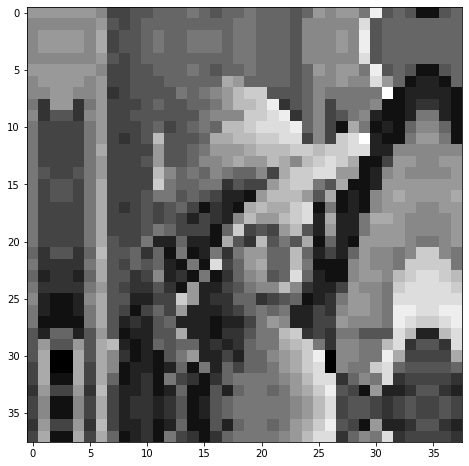

(38, 38)


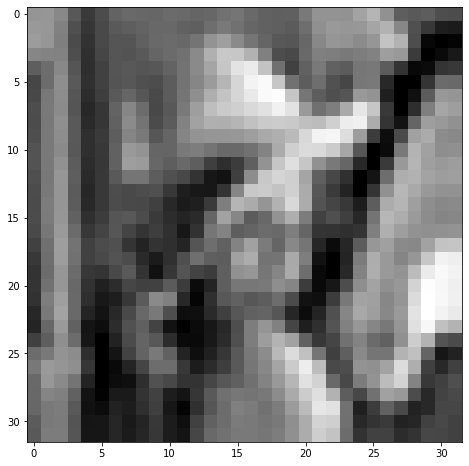

(32, 32)


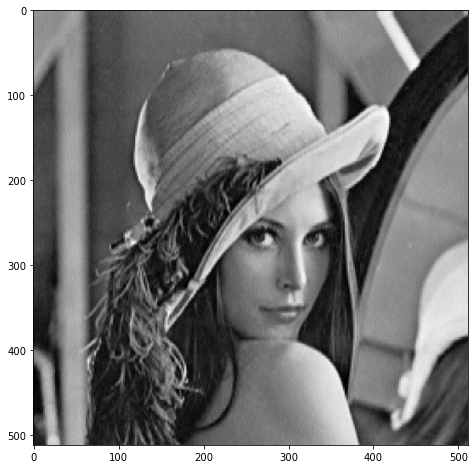

(512, 512)


In [1801]:
offset = int(round((tap+0.5)/2))
print(offset)
im_ext = extend_image(im2, offset)
plt_img(im_ext)
print(im_ext.shape)
w1 = convolve2d(im_ext, G1, mode='valid', boundary='fill')[:-1,1:]
w2 = convolve2d(im_ext, G2, mode='valid', boundary='fill')[1:,:-1]
w3 = convolve2d(im_ext, G3, mode='valid', boundary='fill')[1:,1:]
s = convolve2d(im_ext, H, mode='valid', boundary='fill')[:-1,:-1]
s = shift_img(im, s)
plt_img(s)
print(s.shape)
# plt_img(w1)
# plt_img(w2)
# plt_img(w3)
plt_img(im)
print(im.shape)

In [1809]:
def interp3(image, offset):
    """Upsample an image using bicubic interpolation."""
    # Calculate the new dimensions after upsampling
    new_height = int(image.shape[0] * 2)
    new_width = int(image.shape[1] * 2)

    # Upsample the image using bicubic interpolation
    upsampled_image = scipy.ndimage.zoom(image, zoom=(2, 2), order=3)
    upsampled_image = extend_image(upsampled_image, offset)
    return upsampled_image

def shift_img(im, s):
    # Calculate mean and standard deviation of the first distribution (X)
    mu_X, std_X = np.mean(im), np.std(im)
    # Calculate scale and shift factors
    scale = std_X / np.std(s)
    shift = mu_X - (np.mean(s) * scale)
    # Apply transformation to the second distribution (Y)
    s_transformed = (s * scale) + shift
    s_transformed = np.clip(s_transformed, 0, 255)
    s_transformed = s_transformed.astype(int)
    return s_transformed

def interp(im,offset):
    im_up = np.zeros(np.array(np.shape(im))*2)
    im_up[0::2,0::2] = im;
    kernel = np.array([[1,2,1],[2,4,2],[1,2,1]])/4
    im_up = convolve2d(im_up,kernel,'same')
    im_up = extend_image(im_up, offset)
    return im_up

def interp2(im, offset):
    im_up = np.zeros(np.array(np.shape(im))*2)
    for k in range(0,2):
        for n in range(0,2):
            im_up[k::2,n::2] = im
    im_up = extend_image(im_up, offset)
    return im_up

def extend_image(image, extension_size):
    # Pad the image with its border values to handle boundary effects
    extended_image = np.pad(image, extension_size, mode='symmetric')
    return extended_image

def dwt2d(im, lvl, tap):
    
    h_db1 = np.array([1,1])/np.sqrt(2)
    g_db1 = np.array([1,-1])/np.sqrt(2)

    h_db2 = np.array([0.6830127,1.1830127,0.3169873,-0.1830127])/np.sqrt(2)
    g_db2 = np.array([0.1830127,0.3169873,-1.1830127,0.6830127])/np.sqrt(2)

    h_db3 = np.array([0.47046721,1.14111692,0.650365,-0.19093442,-0.12083221,0.0498175])/np.sqrt(2)
    g_db3 = np.array([-0.0498175,-0.12083221,0.19093442,0.650365,-1.14111692,0.47046721])/np.sqrt(2)

    h = [h_db1,h_db2,h_db3]
    g = [g_db1,g_db2,g_db3]

    h_tap = h[int(tap/2-1)]
    g_tap = g[int(tap/2-1)]

    H, G1, G2, G3 = get2d(h_tap,g_tap)
    H_rev, G1_rev, G2_rev, G3_rev = rev2d(H, G1, G2, G3)
    
    o_height, o_width = im.shape
    coef = np.zeros((o_height, o_width))
    offset = int(round((tap+0.5)/2))
    
    for l in range(lvl):
        
        im = extend_image(im, offset)
        
        w1 = convolve2d(im, G1_rev, mode='valid', boundary='fill')[1:,:-1][0::2, 0::2].astype(int)
        w2 = convolve2d(im, G2_rev, mode='valid', boundary='fill')[:-1,1:][0::2, 0::2].astype(int)
        w3 = convolve2d(im, G3_rev, mode='valid', boundary='fill')[:-1,:-1][0::2, 0::2].astype(int)
        s = convolve2d(im, H_rev, mode='valid', boundary='fill')[1:,1:][0::2, 0::2].astype(int)
        im = s
        
#         plt_img(w1)
#         plt_img(w2)
#         plt_img(w3)
        
        c_height, c_width = im.shape
        
#         print(w1.shape, im.shape)
        
        #top_right
        coef[:c_height,c_width:c_width*2] = w1
        #bottom_left
        coef[c_height:c_height*2,:c_width] = w2
        #bottom_right
        coef[c_height:c_height*2,c_width:c_width*2] = w3
        
#         plt_img(w1)
#         plt_img(w2)
#         plt_img(w3)

    coef[:c_height,:c_width] = im

    return coef

def idwt2d(coef, lvl, tap):
    
    h_db1 = np.array([1,1])/np.sqrt(2)
    g_db1 = np.array([1,-1])/np.sqrt(2)

    h_db2 = np.array([0.6830127,1.1830127,0.3169873,-0.1830127])/np.sqrt(2)
    g_db2 = np.array([0.1830127,0.3169873,-1.1830127,0.6830127])/np.sqrt(2)

    h_db3 = np.array([0.47046721,1.14111692,0.650365,-0.19093442,-0.12083221,0.0498175])/np.sqrt(2)
    g_db3 = np.array([-0.0498175,-0.12083221,0.19093442,0.650365,-1.14111692,0.47046721])/np.sqrt(2)

    h = [h_db1,h_db2,h_db3]
    g = [g_db1,g_db2,g_db3]

    h_tap = h[int(tap/2-1)]
    g_tap = g[int(tap/2-1)]

    H, G1, G2, G3 = get2d(h_tap,g_tap)

    height, width = coef.shape
    
    c_height = int(height/(2**(lvl)))
    c_width = int(width/(2**(lvl)))
    s = coef[:c_height,:c_width]
    
    for l1 in range(lvl):
        
#         print(c_height, c_width)
        offset = int(round((tap+0.5)/2))
        
        w1 = np.zeros(((c_height+offset) * 2, (c_width+offset) * 2))
        w2 = np.zeros(((c_height+offset) * 2, (c_width+offset) * 2))
        w3 = np.zeros(((c_height+offset) * 2, (c_width+offset) * 2))
        
        w1 = interp3(coef[:c_height,c_width:c_width*2], offset)
        w2 = interp3(coef[c_height:c_height*2,:c_width], offset)
        w3 = interp3(coef[c_height:c_height*2,c_width:c_width*2], offset)
        s = interp3(s, offset)
        
#         plt_img(coef[:c_height,c_width:c_width*2])
#         plt_img(w2)
#         plt_img(w3)
#         print("with extension")
#         print(s.shape)

        s_part = convolve2d(s, H, mode='valid', boundary='fill')[:-1,:-1]
        w1_part = convolve2d(w1, G1, mode='valid', boundary='fill')[:-1,1:]
        w2_part = convolve2d(w2, G2, mode='valid', boundary='fill')[1:,:-1]
        w3_part = convolve2d(w3, G3, mode='valid', boundary='fill')[1:,1:]
        
        s = s_part + w1_part + w2_part + w3_part
#         print("after convo")
#         print(s.shape)
        c_height, c_width = s.shape
        
    return s

In [1810]:
im = read_image_as_array("image_512.png")

In [1821]:
level = 2
tap = 6
extension = int((2**(level+1)-2)/2)

In [1822]:
coef = dwt2d(im, level, tap)

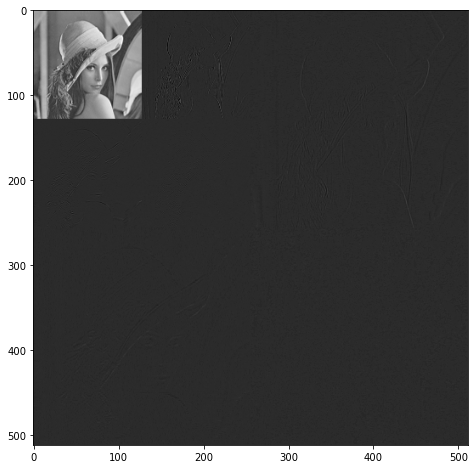

In [1823]:
plt_img(coef)

In [1824]:
x = idwt2d(coef, level, tap)
x = shift_img(im, x)

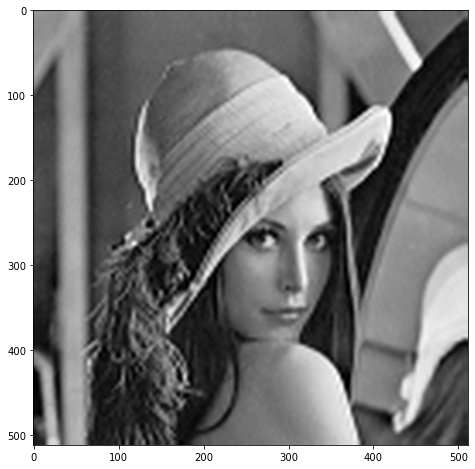

In [1825]:
plt_img(x)

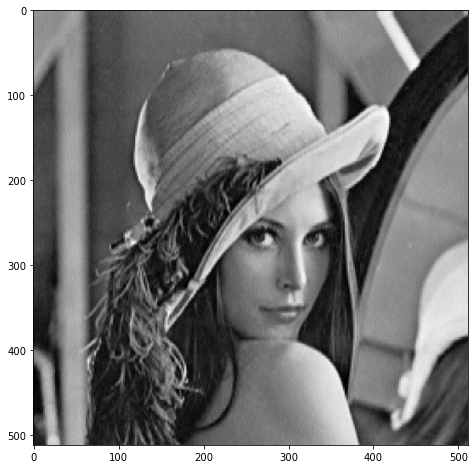

In [1774]:
plt_img(im)

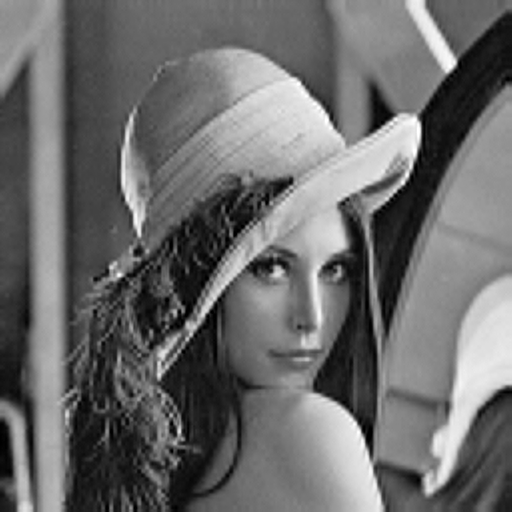

In [1776]:
Image.fromarray(x.astype('uint8'))